In [195]:
import math

import numpy as np
import torch
from kan import KAN as PyKAN
from matplotlib import pyplot as plt
from scipy.interpolate import splev
from torch import nn, optim
from tqdm import tqdm

from efficient_kan.kan import KAN as EffKAN

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Generate the dataset

In [36]:
G = 1  #6.67430e-11


def generate_gravity_dataset(num_samples=1000, noise_std=1e-12):
    m1, m2 = np.random.uniform(0.5, 1, num_samples), np.random.uniform(0.5, 1, num_samples)
    # dx, dy, dz = (np.random.uniform(-1, 1, num_samples),
    #               np.random.uniform(-1, 1, num_samples),
    #               np.random.uniform(-1, 1, num_samples))
    d = np.random.uniform(0.5, 1, num_samples)
    # r = np.sqrt(dx ** 2 + dy ** 2 + dz ** 2)
    r = d
    F = (m1 * m2) / (r ** 2)

    # Add Gaussian noise
    noise = np.random.normal(0, noise_std, num_samples)
    return np.column_stack((m1, m2, d)), F  #+ noise

In [37]:
train_set = generate_gravity_dataset(num_samples=1000, noise_std=1e-12)
test_set = generate_gravity_dataset(num_samples=500, noise_std=1e-12)
dataset = {
    'train_input': torch.tensor(train_set[0], dtype=torch.float32),
    'train_label': torch.tensor(train_set[1], dtype=torch.float32),
    'test_input': torch.tensor(test_set[0], dtype=torch.float32),
    'test_label': torch.tensor(test_set[1], dtype=torch.float32),
}
train_set[0], train_set[1]

(array([[0.67107164, 0.82543115, 0.76420927],
        [0.92930453, 0.95300466, 0.87015757],
        [0.51289269, 0.86847628, 0.83749726],
        ...,
        [0.77131111, 0.99736204, 0.90040476],
        [0.60615264, 0.53365186, 0.66662902],
        [0.94946502, 0.53465353, 0.52197968]]),
 array([0.94847334, 1.16965363, 0.63506426, 0.86803082, 0.43480132,
        2.88821569, 1.23157074, 1.26412622, 0.97328397, 0.9622582 ,
        3.33031248, 1.79132073, 0.66348986, 1.06873967, 1.01430935,
        2.33132139, 0.65036363, 0.49408889, 0.83190861, 1.68576743,
        1.83569512, 1.56120728, 0.56378731, 0.78150135, 2.12338551,
        0.8621171 , 1.40068077, 1.83379537, 1.1632547 , 1.1492557 ,
        0.35958648, 1.0521124 , 0.73093719, 1.53440933, 0.69136624,
        1.2403542 , 1.7426995 , 0.48896686, 0.8120282 , 0.53357366,
        0.80154398, 0.75817006, 1.52485223, 0.77275424, 0.97118773,
        0.58102533, 2.25410349, 1.37192652, 1.13752764, 1.22463957,
        0.46589547, 1.4582687

## Train the KAN

In [32]:
model = PyKAN(width=[3, 3, 3, 3, 1, 1], grid=3, k=3, grid_range=[0.5, 1])
model.fit(dataset, opt="LBFGS", steps=40, lamb=0.01, lamb_entropy=100)
pass

checkpoint directory created: ./model
saving model version 0.0


| train_loss: 7.00e-01 | test_loss: 9.91e+00 | reg: 1.83e+02 | : 100%|█| 40/40 [00:29<00:00,  1.37it

saving model version 0.1


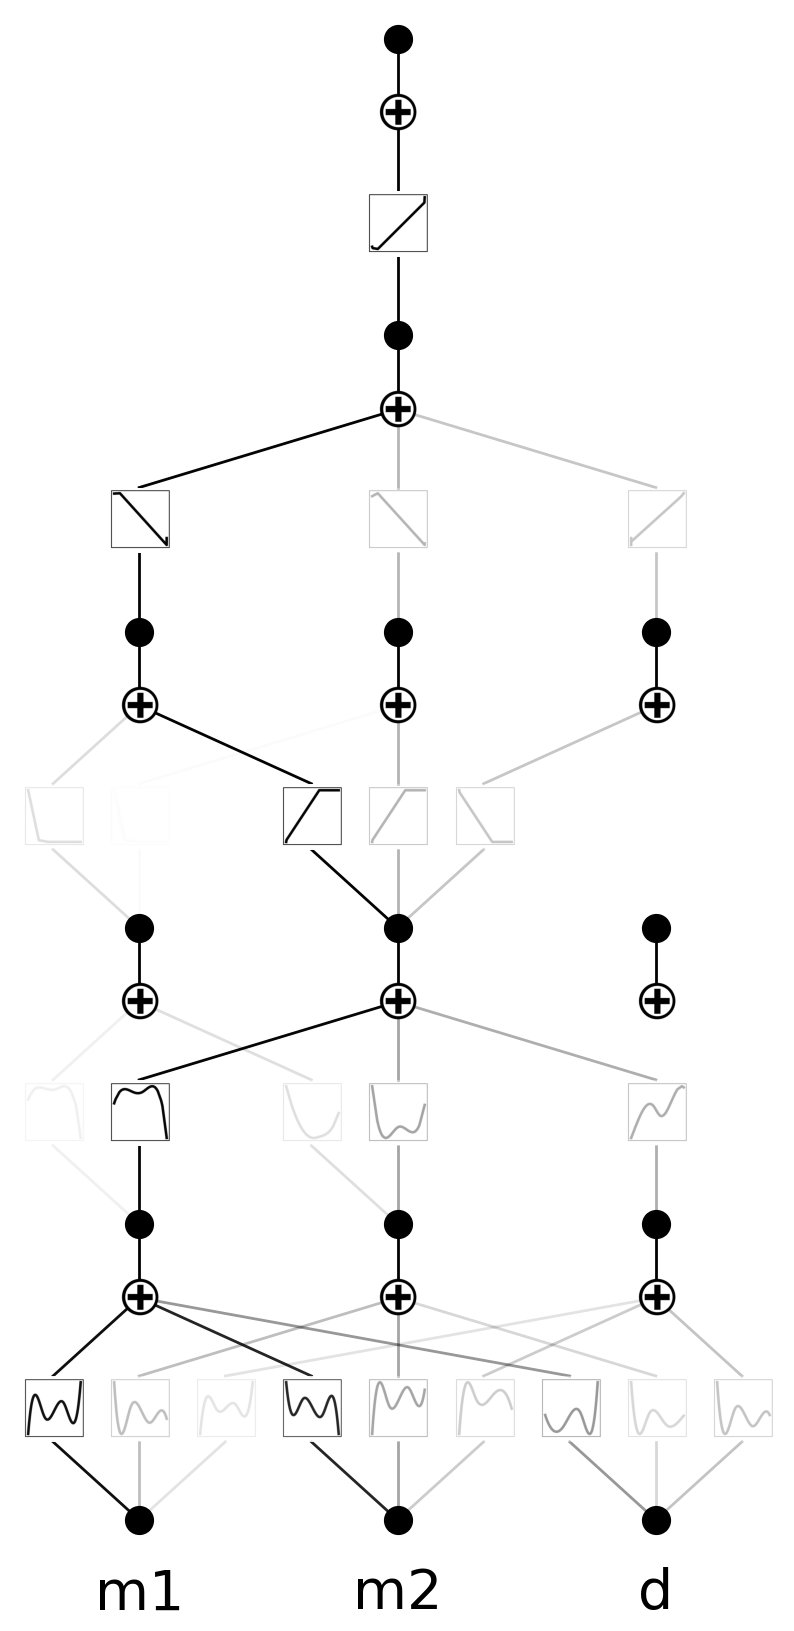

In [33]:
model.plot(in_vars=['m1', 'm2', 'd'], scale=1)

## EfficientKAN

In [38]:
class Efficient_KAN(nn.Module):
    def __init__(self, grid_size=200, shape=None):
        super(Efficient_KAN, self).__init__()
        if shape is None:
            shape = [1, 1]
        self.layers = shape
        self.model = EffKAN(self.layers,
                            grid_size=grid_size,
                            # grid_eps=1,
                            # scale_base=0,
                            # sp_trainable=False,
                            # sb_trainable=False,
                            # enable_standalone_scale_spline=False
                            ).to(device)
        self.double()

    def forward(self, x):
        # x = x / dataset_size * 2 - 1
        # x = x.view(-1, self.layers[0])
        x = self.model(x)
        return x

In [39]:
def train(model, optimizer, inputs: torch.Tensor, labels, epochs=5, batch_size=100):
    criterion = nn.MSELoss()
    scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.999)
    for epoch in range(epochs):
        model.train()
        with tqdm(range(inputs.size(0) // batch_size)) as pbar:
            for i in pbar:
                x = inputs[i * batch_size:(i + 1) * batch_size].to(device)
                y = labels[i * batch_size:(i + 1) * batch_size].to(device)
                optimizer.zero_grad()
                output = model(x)
                output = output.squeeze()
                loss = criterion(output, y.double())
                loss.backward()
                optimizer.step(closure=lambda: loss)
                pbar.set_postfix(loss=loss.item(), lr=optimizer.param_groups[0]['lr'])
                scheduler.step()

In [123]:
def test(model, inputs, labels, batch_size=100):
    model.eval()
    criterion = nn.MSELoss()
    losses = []
    with torch.no_grad():
        with tqdm(range(inputs.size(0) // batch_size)) as pbar:
            for i in pbar:
                x = inputs[i * batch_size:(i + 1) * batch_size].to(device)
                y = labels[i * batch_size:(i + 1) * batch_size].to(device)
                output = model(x).cpu()
                output = output.squeeze()
                losses.append(criterion(output, y.double()))
    return (sum(losses) / len(losses)).item()

In [49]:
model2 = Efficient_KAN(grid_size=4, shape=[3, 3, 3, 3, 1, 1])

In [53]:
train(model2, optim.Adam(model2.parameters(), lr=0.025), dataset["train_input"], dataset["train_label"], epochs=100,
      batch_size=100)

100%|██████████| 10/10 [00:00<00:00, 131.28it/s, loss=5.99e-5, lr=0.0092]


In [124]:
test(model2, dataset["test_input"], dataset["test_label"])

100%|██████████| 5/5 [00:00<00:00, 344.49it/s]


5.9409552071750294e-05

In [214]:
import random


def plot_spline(model: EffKAN, x_range):
    base_colors = [(1, 0, 0), (0, 1, 0), (0, 0, 1)]

    def random_color():
        return random.random(), random.random(), random.random()

    colors = [base_colors[x] if x < len(base_colors) else random_color()
              for x in range(max(map(lambda l: l.in_features, model.layers)))]
    k = model.spline_order
    grid_size = model.grid_size
    for layer in reversed(model.layers):
        fig, axes = plt.subplots(1, layer.in_features * layer.out_features,
                                 figsize=(2 * layer.in_features * layer.out_features, 2))
        for i in range(layer.in_features):
            for j in range(layer.out_features):
                x_vals = np.linspace(x_range[0], x_range[1], 50)
                coeff = (
                    torch.arange(-k, grid_size + k + 1 * (x_range[1] - x_range[0]) / grid_size + x_range[0]),
                    layer.spline_weight[j, i].detach().numpy(),
                    k
                )
                y_vals = splev(x_vals, coeff)
                alpha = math.tanh(abs(layer.base_weight[j, i].item()))
                if type(axes) is np.ndarray:
                    axes[i * layer.out_features + j].plot(x_vals, y_vals, alpha=alpha, color=colors[i])
                else:
                    axes.plot(x_vals, y_vals, alpha=alpha, color=colors[i])

    plt.tight_layout()
    plt.show()

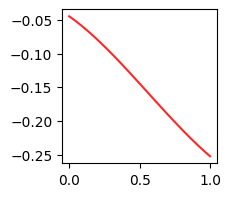

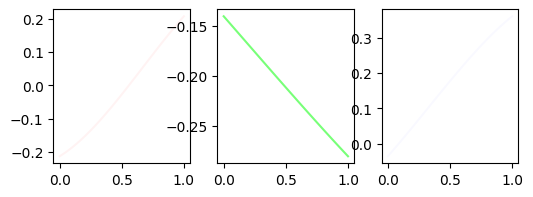

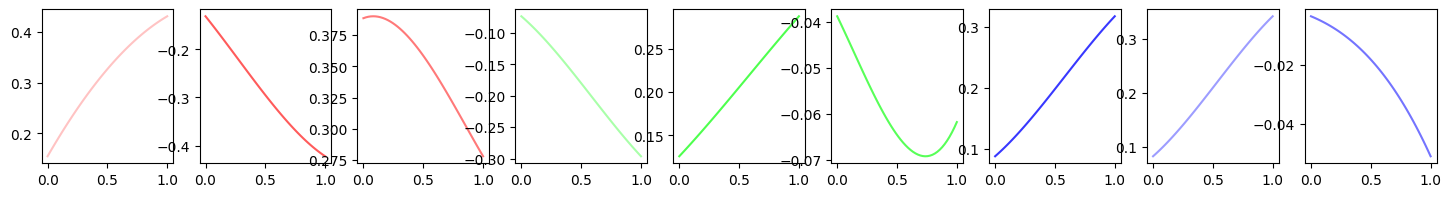

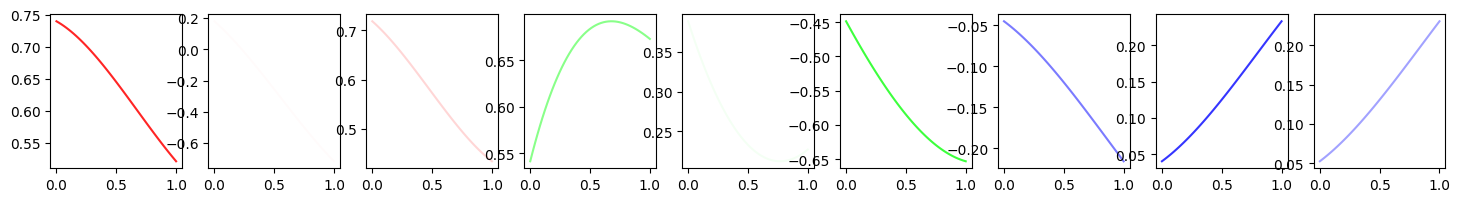

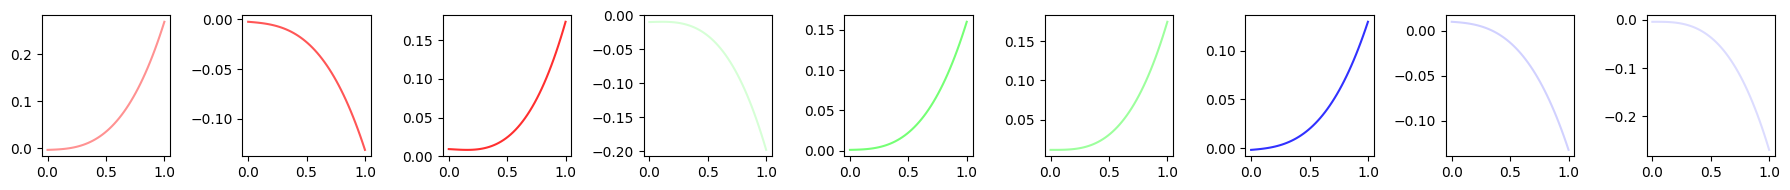

In [215]:
plot_spline(model2.model, [0, 1])